In [73]:
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import matplotlib.colorbar as colorbar
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm




def initialize(timesteps):
    ''' initialize the physical system, horizontal grid size, etc
    '''  
    # below are the parameters that can be varied
    dx = 1.
    u = 5.
    dz = 1.
    v = 5.
    dt = 0.01#dx/v
    Numpoints = 30
    shift = Numpoints/5
    c_0 = 1.0
    alpha =  0.01*10
    epsilon = 0.0001
    
# create the concentration matrix and initialize it
    cmatrix = np.zeros((timesteps+1, Numpoints+4,Numpoints+4))
    for j in range(5,10):
        cmatrix[0, j,2:Numpoints+2]= c_0 * np.exp(- alpha * (np.arange(0,Numpoints)* dx -shift)**2)
    
# set the boundary points
    cmatrix = boundary_conditions(cmatrix, 0, Numpoints)

    return dx, dz, u, v, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix

def boundary_conditions(cmatrix, time, Numpoints):
    '''Set boundary conditions (double thick so it work for Bott Scheme as well as central and upstream
    '''
    cmatrix[0, 0,:] = cmatrix[1, Numpoints-1,:]
    cmatrix[0, 1,:] = cmatrix[1, Numpoints,:]
    cmatrix[0, Numpoints+2,:] = cmatrix[1, 3,:]
    cmatrix[0, Numpoints+3,:] = cmatrix[1, 4,:]
    
    cmatrix[0, :,0] = cmatrix[1, :,Numpoints-1]
    cmatrix[0, :,1] = cmatrix[1, :,Numpoints]
    cmatrix[0, :,Numpoints+2] = cmatrix[1, :,3]
    cmatrix[0, :,Numpoints+3] = cmatrix[1, :,4]
    
    return cmatrix


def advect3_gettable(order, Numpoints):
    
    '''read in the corresponding coefficient table for the calculation of coefficients for advection3
    '''

# create a matrix to store the table to be read in
    temp = np.zeros(5)
    ltable = np.zeros((order + 1, 5))

    fname = 'numeric/numlabs/lab10/Tables/l{0}_table.txt'.format(order)
    fp = open(fname, 'r')
 
    for i in range(order+1):
        line = fp.readline()
        temp = line.split()
        ltable[i, :]= temp
        
    fp.close()
    return ltable

    

def step_advect_x(timesteps, ltable, cmatrix, order, Numpoints, u, dt, dx, epsilon):
    '''Step algorithm for Bott Scheme'''
    amatrix = np.zeros((order+1, Numpoints))
    
    for timecount in range(0,timesteps):
        for numx in range (2,Numpoints+2):
            for base in range(0,5):
                amatrix[0:order+1, 0:Numpoints] += np.dot(
                    ltable[0:order+2, base:base+1], 
                    cmatrix[timecount:timecount+1,numx, 0+base:Numpoints+base])

    # calculate I of c at j+1/2 , as well as I at j
            Iplus = np.zeros(Numpoints)
            Iatj = np.zeros(Numpoints)

            tempvalue= 1 - 2*u*dt/dx
            
            for k in range(order+1):
                Iplus += amatrix[k] * (1- (tempvalue**(k+1)))/(k+1)/(2**(k+1))
                Iatj += amatrix[k] * ((-1)**k+1)/(k+1)/(2**(k+1))
            Iplus[Iplus < 0] = 0
            Iatj = np.maximum(Iatj, Iplus + epsilon)

    # finally, calculate the current concentration 
            cmatrix[timecount+1, numx,3:Numpoints+2] = (
                cmatrix[timecount, numx,3:Numpoints+2] * 
                (1 - Iplus[1:Numpoints]/ Iatj[1:Numpoints]) + 
                 cmatrix[timecount, numx, 2:Numpoints+1]* 
                 Iplus[0:Numpoints-1]/ Iatj[0:Numpoints-1])
              
# set the boundary condition at the first point
        cmatrix[timecount+1, 2,:]= cmatrix[timecount+1, Numpoints+1,:]
        #cmatrix[timecount+1, :,2]= cmatrix[timecount+1, :,Numpoints+1]
# set the other boundary points
        #cmatrix = boundary_conditions(cmatrix, timecount+1, Numpoints)
    return cmatrix    
    
    
    
def step_advect_xz(timesteps, ltable, cmatrix, order, Numpoints, u, v, dt, dx, dz, epsilon):
    '''Step algorithm for Bott Scheme'''
    amatrix = np.zeros((order+1, Numpoints))
    
    for timecount in range(0,timesteps):
        # concentration in z dir
        for numz in range (2,Numpoints+2):
            for base in range(0,5):
                amatrix[0:order+1, 0:Numpoints] += np.dot(
                    ltable[0:order+2, base:base+1], 
                    cmatrix[timecount:timecount+1, 0+base:Numpoints+base,numz])

            Iplus = np.zeros(Numpoints)
            Iatj = np.zeros(Numpoints)
            
            tempvalue= 1 - 2*v*dt/dz
            
            for k in range(order+1):
                Iplus += amatrix[k] * (1- (tempvalue**(k+1)))/(k+1)/(2**(k+1))
                Iatj += amatrix[k] * ((-1)**k+1)/(k+1)/(2**(k+1))
            Iplus[Iplus < 0] = 0
            Iatj = np.maximum(Iatj, Iplus + epsilon)

    
            cmatrix[timecount, 3:Numpoints+2,numz] = (
                cmatrix[timecount, 3:Numpoints+2,numz] * 
                (1 - Iplus[1:Numpoints]/ Iatj[1:Numpoints]) + 
                 cmatrix[timecount, 2:Numpoints+1,numz]* 
                 Iplus[0:Numpoints-1]/ Iatj[0:Numpoints-1])
        
        cmatrix[timecount, :,2]= cmatrix[timecount, :,Numpoints+1]
        
        # concentration in x dir
        for numx in range (2,Numpoints+2):
            for base in range(0,5):
                amatrix[0:order+1, 0:Numpoints] += np.dot(
                    ltable[0:order+2, base:base+1], 
                    cmatrix[timecount:timecount+1,numx, 0+base:Numpoints+base])

            Iplus = np.zeros(Numpoints)
            Iatj = np.zeros(Numpoints)

            tempvalue= 1 - 2*u*dt/dx
            for k in range(order+1):
                Iplus += amatrix[k] * (1- (tempvalue**(k+1)))/(k+1)/(2**(k+1))
                Iatj += amatrix[k] * ((-1)**k+1)/(k+1)/(2**(k+1))
            Iplus[Iplus < 0] = 0
            Iatj = np.maximum(Iatj, Iplus + epsilon)

    
            cmatrix[timecount+1, numx,3:Numpoints+2] = (
                cmatrix[timecount, numx,3:Numpoints+2] * 
                (1 - Iplus[1:Numpoints]/ Iatj[1:Numpoints]) + 
                 cmatrix[timecount, numx, 2:Numpoints+1]* 
                 Iplus[0:Numpoints-1]/ Iatj[0:Numpoints-1])                      
            
# set the boundary condition at the first point
        cmatrix[timecount+1, 2,:]= cmatrix[timecount+1, Numpoints+1,:]
        cmatrix[timecount+1, :,2]= cmatrix[timecount+1, :,Numpoints+1]

    return cmatrix


def advection3(timesteps, order,string):
    ''' Entry point for the Bott Scheme'''
    dx, dz, u, v, dt, Numpoints, shift, c_0, alpha, epsilon, cmatrix = initialize(timesteps)
    ltable = advect3_gettable(order, Numpoints)
    #cmatrix = step_advect_x(timesteps, ltable, cmatrix, order, Numpoints, u=500, dt=0.1, dx=dx, epsilon=epsilon)
    cmatrix = step_advect_xz(timesteps, ltable, cmatrix, order, Numpoints, u=u, v=v, dt=100./500., dx=dx, dz=dz, epsilon=epsilon)
    return cmatrix, timesteps, Numpoints, dt
    

In [71]:
def plotbathy(Hu,x,y,timestep,j1,j2,j3):
    
    
    #fig = plt.figure(figsize=(12,5))
    ax = fig.add_subplot(j1, j2, j3+1, projection='3d')
    X = np.linspace(0, x,x,endpoint=False)
    Y = np.linspace(0, y,y,endpoint=False)
    X, Y = np.meshgrid(X, Y)
    Z = Hu[timestep,2:-2:,2:-2:]#(Hu**2+Hv**2)**0.5
    
    ax.plot_surface(X, Y, Z, rstride=1, cstride=1, alpha=0.05)
    cset = ax.contour(X, Y, Z, zdir='z', offset=Z.max(), cmap=cm.coolwarm,alpha=0.3)
    cset = ax.contour(X, Y, Z, zdir='x', offset=X.min(), cmap=cm.coolwarm,alpha=0.3)
    cset = ax.contour(X, Y, Z, zdir='y', offset=Y.max(), cmap=cm.coolwarm,alpha=0.3)
    ax.set_title('t:%s'%timestep)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #ax.set_zlabel('t:%s'%timestep)
    ax.invert_zaxis()

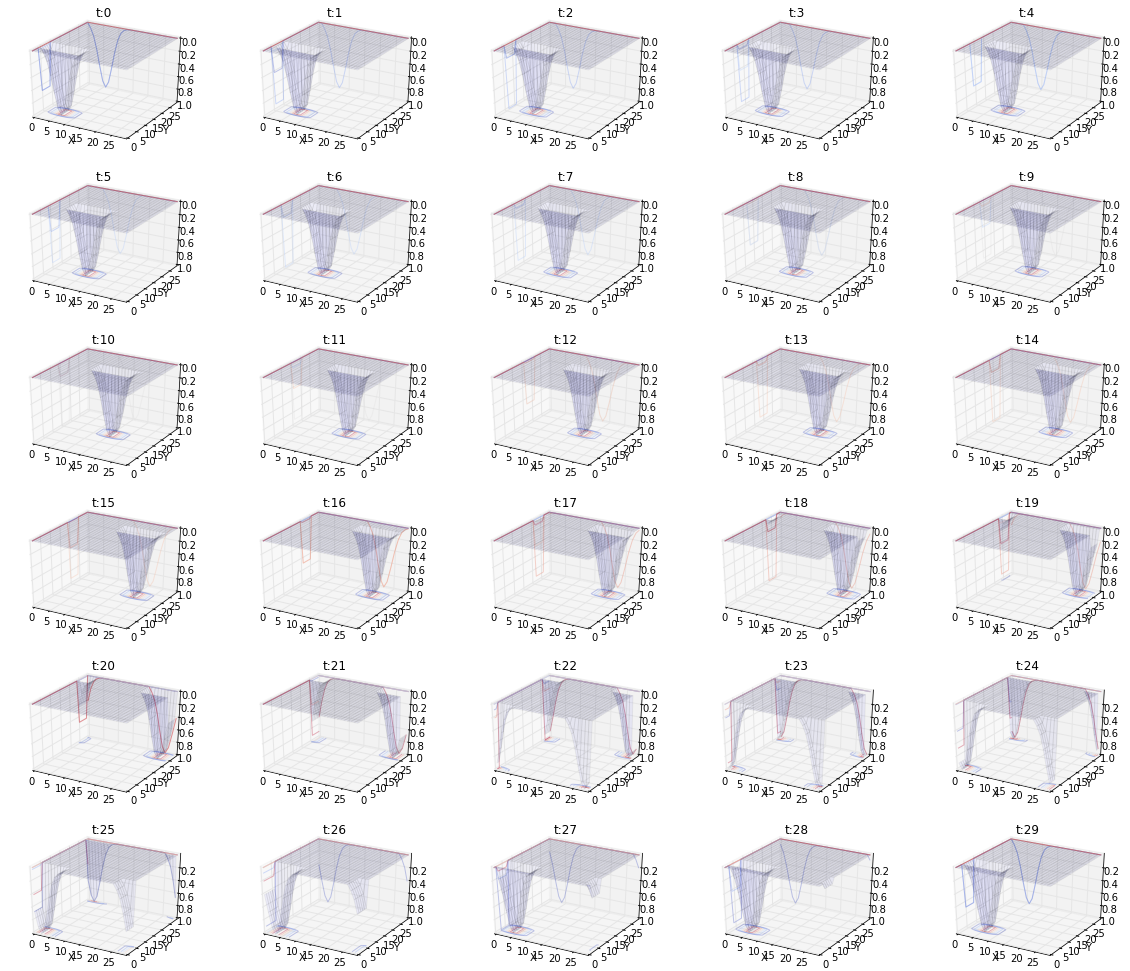

In [72]:
%matplotlib inline
coeff=5
t=30*coeff
a1,b1,c1,d1=advection3(t,4,'0') #24*3600*20,24h
fig = plt.figure(figsize=(20,20))
for j in range (t):
    k=j%coeff
    if k==0:
        plotbathy(a1,30,30,timestep=j/coeff,j1=7,j2=5,j3=j/coeff)
plt.show()

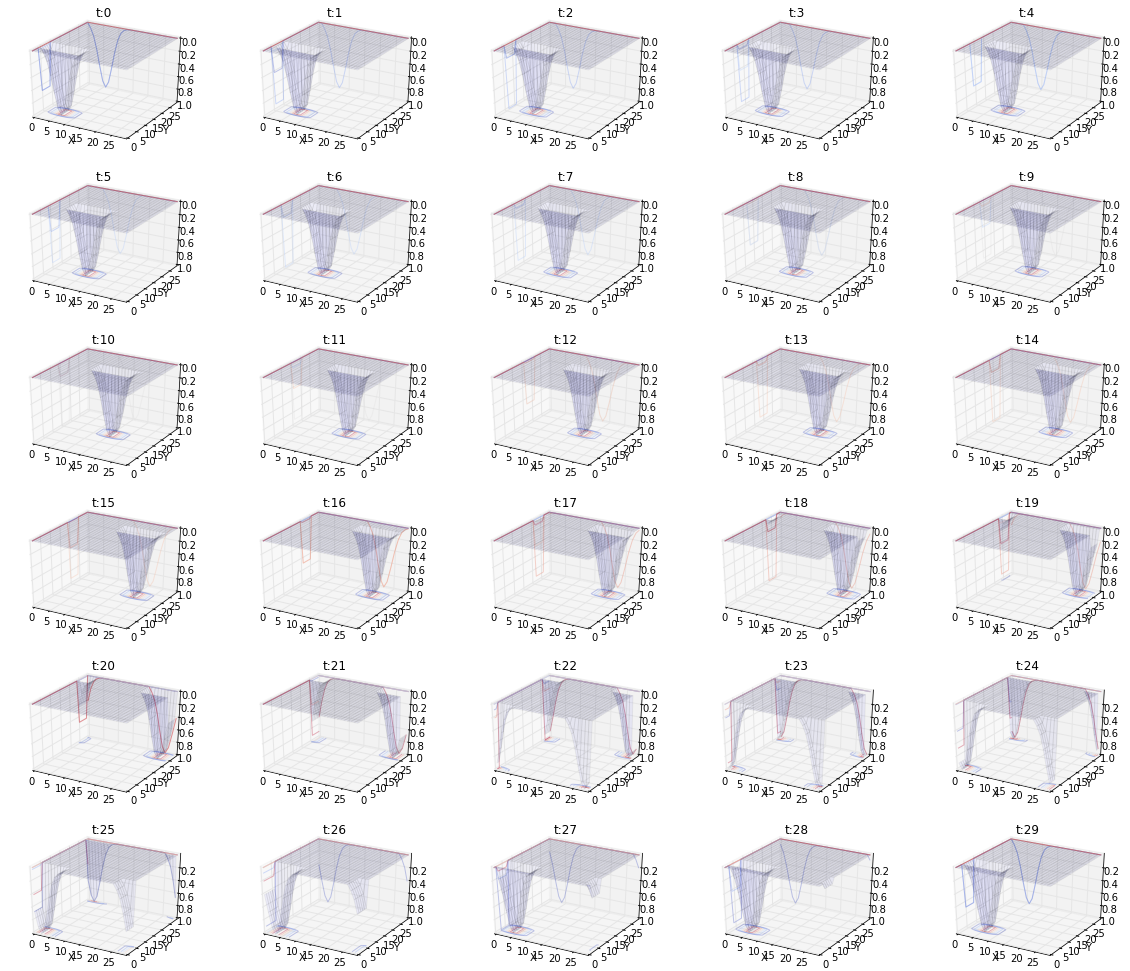

In [74]:
coeff=100
t=30*coeff
a1,b1,c1,d1=advection3(t,4,'0') #24*3600*20,24h
fig = plt.figure(figsize=(20,20))
for j in range (t):
    k=j%coeff
    if k==0:
        plotbathy(a1,30,30,timestep=j/coeff,j1=7,j2=5,j3=j/coeff)
plt.show()